# Examples with PI/PID feedback control

PSD I (2026), Philipp Schlatter and Siavash Toosi


## 1. Cruise control

In [1]:
%matplotlib widget

### 1.1 PI Controller

The differential equation of the plant is

$$ m\frac{\mathrm{d} v}{\mathrm{d}t} = F_\mathrm{engine} - b\cdot v $$

The plant transfer function becomes 

$$ G(s) = \frac{Y(s)}{U(s)} = \frac{1}{m s + b}$$

With the feedback control we get

$$ T(s) = \frac{V(s)}{V_{sp}} = \frac{ C(s) G(s) }{1+C(s) G(s)} $$

The transfer function of a PI controller is 

$$C(s) = K_p + \frac{K_i}{s}$$

Closing the loop we get

$$T(s) = \frac{(K_p s + K_i) G(s)}{s + (K_p s + K_i) G(s)}$$

With the transfer function of the plant

$$G(s) = \frac{1}{ms + b}  $$
we get: 

$$T(s) = \frac{K_p s + K_i}{ms^2 + (b + K_p)s + K_i}$$



#### Settling time and overshoot
We can now compare the denominator to the standard second-order form $s^2 + 2\zeta\omega_n s + \omega_n^2$ (after dividing by $m$) to tune your gains $K_p$ and $K_i$ for a specific overshoot or settling time.

- Natural Frequency ($\omega_n$): Matching the constant term: $\omega_n^2 = \frac{K_i}{m}$

$$\omega_n = \sqrt{\frac{K_i}{m}}$$

- Damping Ratio ($\zeta$): Matching the $s$ term: $2\zeta\omega_n = \frac{b + K_p}{m}$

$$\zeta = \frac{b + K_p}{2\sqrt{m K_i}}$$

For a standard second-order system, these values are calculated using $\zeta$ and $\omega_n$.

- Settling Time ($T_s$): Using the 2% criterion (the time it takes to stay within 2% of the final value):

$$T_s \approx \frac{4}{\zeta\omega_n} = \frac{4}{\frac{b + K_p}{2m}}$$

$$T_s = \frac{8m}{b + K_p}$$

- Percent Overshoot ($OS\%$): The overshoot depends solely on the damping ratio $\zeta$:

$$OS\% = 100 e^{-\left( \frac{\zeta\pi}{\sqrt{1-\zeta^2}} \right)}$$





#### The Effect of the Zero in the numerator

It is important to note that your transfer function has a zero in the numerator at $s = -K_i/K_p$.

- Increased Overshoot: In a real-world PI controlled system, the overshoot will actually be higher than the formula above predicts. The zero adds "lead" to the system, which speeds up the rise time but typically causes a larger peak.
- Settling Time: The settling time formula remains a very good approximation, as the decay is still dominated by the real part of the poles ($\zeta\omega_n$).

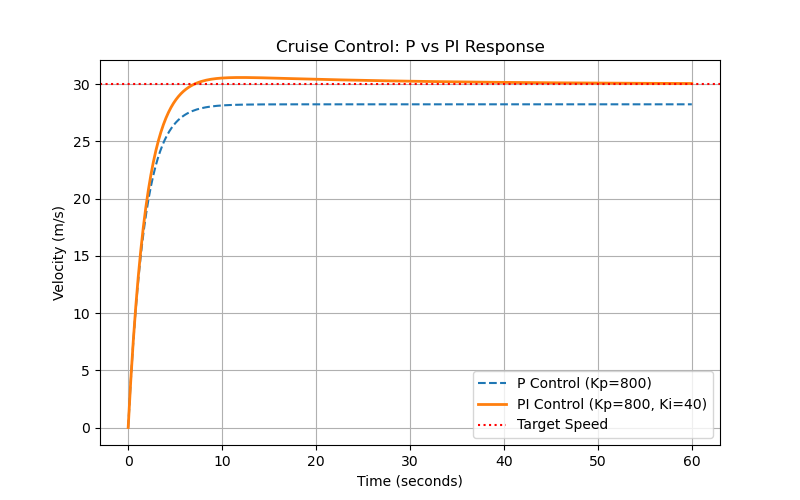

PI Controller TF:
<TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  800 s + 40
  ----------
      s
Closed-Loop (PI) TF:
<TransferFunction>: sys[8]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       800 s + 40
  ---------------------
  1500 s^2 + 850 s + 40


In [2]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Define System Parameters
m = 1500    # Mass
b = 50      # Friction
Kp = 800    # Proportional Gain
Ki = 40     # Integral Gain (New)
v_target = 30 

# Define the Plant G(s) = 1 / (ms + b)
G = ct.TransferFunction([1], [m, b])

# Define the P-only Controller (for comparison)
C_p = ct.TransferFunction([Kp], [1])
cl_p = ct.feedback(C_p * G)

# Define the PI Controller C(s) = (Kp*s + Ki) / s
C_pi = ct.TransferFunction([Kp, Ki], [1, 0])
cl_pi = ct.feedback(C_pi * G)

# Simulation: Step Responses
t_p, v_p   = ct.step_response(cl_p, T=60)
t_pi, v_pi = ct.step_response(cl_pi, T=60)

# Scale by target velocity
v_p  = v_p  * v_target
v_pi = v_pi * v_target

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(t_p, v_p, label=f'P Control (Kp={Kp})', linestyle='--')
plt.plot(t_pi, v_pi, label=f'PI Control (Kp={Kp}, Ki={Ki})', linewidth=2)
plt.axhline(y=v_target, color='r', linestyle=':', label='Target Speed')

plt.title('Cruise Control: P vs PI Response')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.legend()
plt.show()

print(f"PI Controller TF:\n{C_pi}")
print(f"Closed-Loop (PI) TF:\n{cl_pi}")

### 1.2 Interactive PI controller

Output()

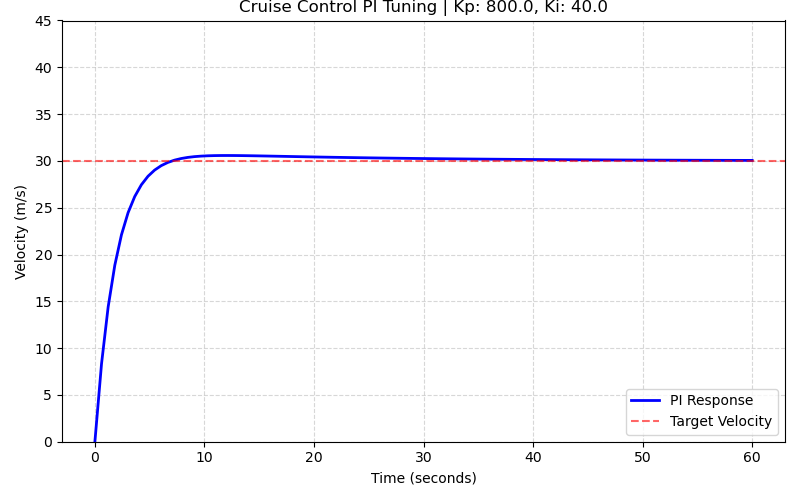

In [3]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Use the widget backend for interactive property updates without redrawing
%matplotlib widget

# Setup Data and Plant
m, b, v_target = 1500, 50, 30
time = np.linspace(0, 60, 100)
G = ct.TransferFunction([1], [m, b])

# Initialize Figure
# We create the figure once and keep the reference
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot(time, np.zeros_like(time), lw=2, color='blue', label='PI Response')
ax.axhline(y=v_target, color='red', linestyle='--', alpha=0.6, label='Target Velocity')

ax.set_ylim(0, v_target * 1.5)
ax.set_xlim(-3, 63)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Velocity (m/s)')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend(loc='lower right')
plt.tight_layout()

# Update Function
def update_system(Kp, Ki):
    # Calculate PI Controller: C = (Kp*s + Ki) / s and the feedback loop
    C = ct.TransferFunction([Kp, Ki], [1, 0])
    T = ct.feedback(C * G)
    
    # Simulate Step Response
    _, v = ct.step_response(T, T=time)
    v = v * v_target
    
    # Update the existing line data instead of redrawing the plot
    line.set_ydata(v)
    ax.set_title(f'Cruise Control PI Tuning | Kp: {Kp:.1f}, Ki: {Ki:.1f}')
    fig.canvas.draw_idle()

# Interactive Elements
kp_slider = widgets.FloatSlider(value=800, min=0, max=2000, step=10, description='Kp')
ki_slider = widgets.FloatSlider(value=40, min=0, max=200, step=1, description='Ki')

# Use interactive_output to connect sliders to the function without the flickering
ui = widgets.VBox([kp_slider, ki_slider])
out = widgets.interactive_output(update_system, {'Kp': kp_slider, 'Ki': ki_slider})

display(out,ui)

### 2. PID Controller

Output()

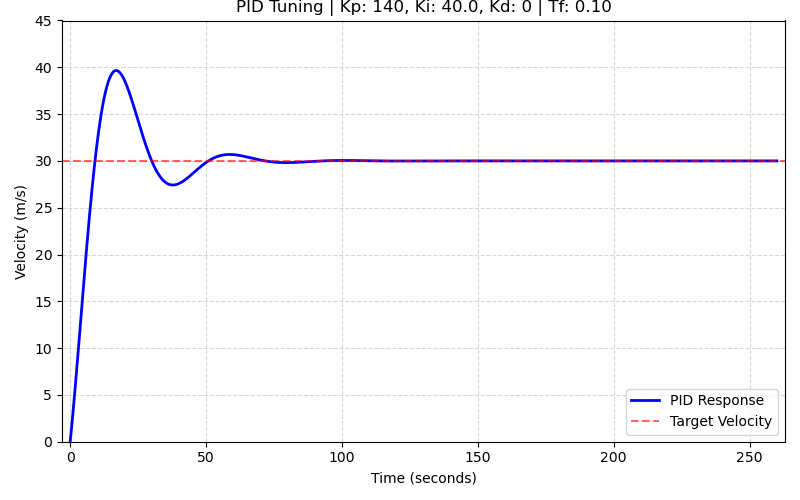

In [4]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

%matplotlib widget

# Setup Data and Plant
m, b, v_target = 1500, 50, 30
time = np.linspace(0, 260, 1000)
G = ct.TransferFunction([1], [m, b])

# Initialize Figure
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot(time, np.zeros_like(time), lw=2, color='blue', label='PID Response')
ax.axhline(y=v_target, color='red', linestyle='--', alpha=0.6, label='Target Velocity')

ax.set_ylim(0, v_target * 1.5)
ax.set_xlim(-3, 263)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Velocity (m/s)')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend(loc='lower right')
plt.tight_layout()

# Update Function
def update_system(Kp, Ki, Kd):
    # PID Controller: C = (Kd*s^2 + Kp*s + Ki) / s
    # Note: In practice, D-terms often include a low-pass filter to handle noise,
    # but here we use the ideal form.
    C = ct.TransferFunction([Kd, Kp, Ki], [1, 0])
    
    # Tf is the derivative filter time constant. 
    # A smaller Tf makes it behave more like an ideal D, 
    # but a non-zero Tf ensures velocity starts at 0.
    # Filtered PID formula: Kp + Ki/s + (Kd*s)/(Tf*s + 1)
    # Combined into a single Transfer Function:
    # num = (Kp*Tf + Kd)s^2 + (Kp + Ki*Tf)s + Ki
    # den = Tf*s^2 + s   
    Tf = .1     
    C = ct.TransferFunction([Kp*Tf + Kd, Kp + Ki*Tf, Ki], [Tf, 1, 0])
    
    # Calculate Closed-Loop Transfer Function
    T = ct.feedback(C * G)
    
    # Simulate Step Response
    _, v = ct.step_response(T, T=time)
    v = v * v_target
    
    # Update data
    line.set_ydata(v)
    ax.set_title(f'PID Tuning | Kp: {Kp:.0f}, Ki: {Ki:.1f}, Kd: {Kd:.0f} | Tf: {Tf:.2f}')
    fig.canvas.draw_idle()

# Interactive Elements
kp_slider = widgets.FloatSlider(value=140, min=0, max=5000, step=50, description='Kp')
ki_slider = widgets.FloatSlider(value=40, min=0, max=400, step=1, description='Ki')
kd_slider = widgets.FloatSlider(value=00, min=0, max=10000, step=20, description='Kd')

ui = widgets.VBox([kp_slider, ki_slider, kd_slider])
out = widgets.interactive_output(update_system, {'Kp': kp_slider, 'Ki': ki_slider, 'Kd': kd_slider})

display(ui, out)